In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import pyspark.sql.functions as F
import pyspark as ps
from pyspark import SQLContext

In [2]:
spark = ps.sql.SparkSession.builder \
    .master('local[2]') \
    .appName('spark-ml') \
    .getOrCreate()

sc = spark.sparkContext

In [3]:
sqlContext = SQLContext(sc)

In [4]:
# read CSV
df_fb = sqlContext.read.csv('English Premier League stats 2019-2020/players_1920_fin.csv',
                         header=True,       # use headers or not
                         quote='"',         # char for quotes
                         sep=",",           # char for separation
                         inferSchema=True)  # do we infer schema or not ?

In [5]:
# Select individual columns 
# Rename full column to player
df_fb = df_fb.select("kickoff_time","goals_scored","own_goals","goals_conceded","team","full").\
    withColumnRenamed("full","player")

In [6]:
# Select only results for team == "Man Utd" (Manchester United)
df_fb = df_fb.filter(df_fb["team"] == "Man Utd")
df_fb.show(5)

+-------------------+------------+---------+--------------+-------+-----------------+
|       kickoff_time|goals_scored|own_goals|goals_conceded|   team|           player|
+-------------------+------------+---------+--------------+-------+-----------------+
|2019-08-11 15:30:00|           0|        0|             0|Man Utd|Aaron Wan-Bissaka|
|2019-08-19 19:00:00|           0|        0|             1|Man Utd|Aaron Wan-Bissaka|
|2019-08-24 14:00:00|           0|        0|             2|Man Utd|Aaron Wan-Bissaka|
|2019-08-31 11:30:00|           0|        0|             1|Man Utd|Aaron Wan-Bissaka|
|2019-09-14 14:00:00|           0|        0|             0|Man Utd|Aaron Wan-Bissaka|
+-------------------+------------+---------+--------------+-------+-----------------+
only showing top 5 rows



In [7]:
df_matches = df_fb.select("kickoff_time").dropDuplicates()

In [8]:
# Min
df_min = df_fb.groupBy("player").\
    min("goals_scored")

# Max
df_max = df_fb.groupBy("player").\
    max("goals_scored")

# Median
df_fb.registerTempTable("df")
df_med = sqlContext.sql("select player, percentile_approx( float(goals_scored), 0.5) as Median from df group by player")

# Lower Quartile
df_lq = sqlContext.sql("select player, percentile_approx(float(goals_scored), 0.25) as Lower_Quartile from df group by player")

# Upper Quartile
df_uq = sqlContext.sql("select player, percentile_approx(float(goals_scored), 0.75) as Upper_Quartile from df group by player")


In [9]:
# Join all the dataframes into one
df_summary = df_fb.select("player").dropDuplicates()
dfs = [df_min, df_max, df_med, df_lq, df_uq]

for df in dfs:
    df_summary = df_summary.join(df, df_summary.player == df.player, 'inner').drop(df.player)

df_summary = df_summary.withColumnRenamed("min(goals_scored)", "Minimum").\
            withColumnRenamed("max(goals_scored)", "Maximum")

In [10]:
df_summary.show(df_summary.count())

+--------------------+-------+-------+------+--------------+--------------+
|              player|Minimum|Maximum|Median|Lower_Quartile|Upper_Quartile|
+--------------------+-------+-------+------+--------------+--------------+
|        James Garner|      0|      0|   0.0|           0.0|           0.0|
|       Harry Maguire|      0|      1|   0.0|           0.0|           0.0|
|           Lee Grant|      0|      0|   0.0|           0.0|           0.0|
|Frederico Rodrigu...|      0|      0|   0.0|           0.0|           0.0|
|        Ashley Young|      0|      0|   0.0|           0.0|           0.0|
|          Paul Pogba|      0|      1|   0.0|           0.0|           0.0|
|       Nemanja Matic|      0|      0|   0.0|           0.0|           0.0|
|         Angel Gomes|      0|      0|   0.0|           0.0|           0.0|
|           Luke Shaw|      0|      0|   0.0|           0.0|           0.0|
|     Andreas Pereira|      0|      1|   0.0|           0.0|           0.0|
|           

In [11]:
players = df_fb.orderBy("player").\
            select("player","goals_scored")

In [12]:
player_names = players.select("player").drop_duplicates().\
    rdd.flatMap(lambda x: x).\
    collect()

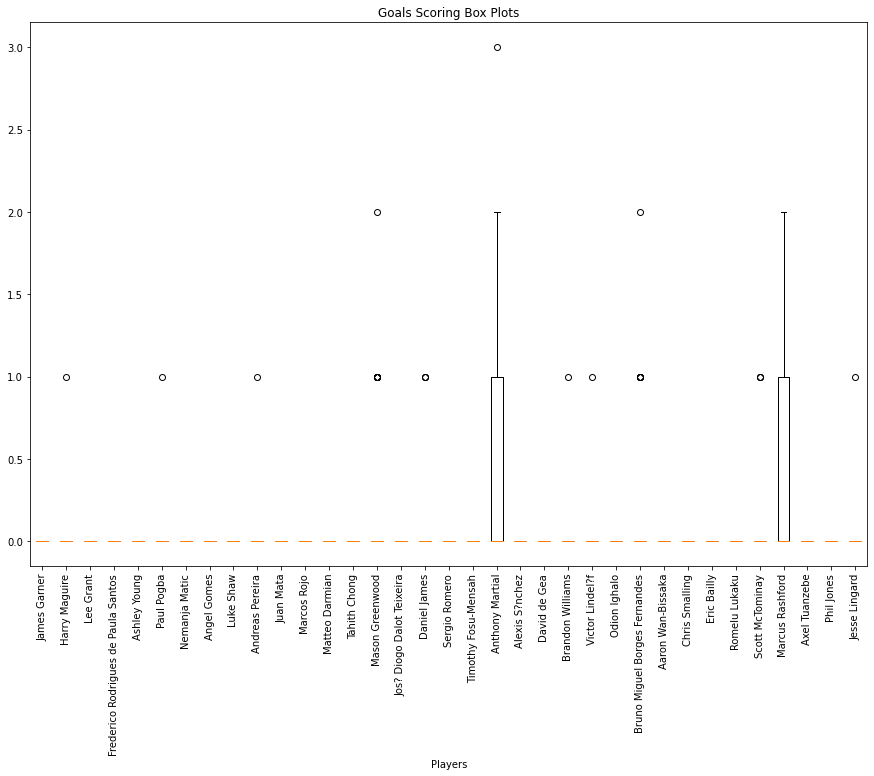

In [42]:
from itertools import chain, repeat, islice

def pad_infinite(iterable, padding=None):
   return chain(iterable, repeat(padding))

def pad(iterable, size, padding=None):
   return islice(pad_infinite(iterable, padding), size)

df = pd.DataFrame()

goals_dict = {}

for name in player_names:
    goals_scored = players.filter(df_fb["player"] == name).\
        select("goals_scored").\
        rdd.flatMap(lambda x: x).\
        collect()
    
    goals_dict[name] = goals_scored
    

max_len = 0

for key, value in goals_dict.items():
    if len(value) > max_len:
        max_len = len(value)
     

for key, value in goals_dict.items():
    goals_scored = list(pad(value, max_len, 0))
    df[key] = goals_scored
    
fig, axs = plt.subplots(figsize=(15, 10))
# fig.figsize(800,500)
axs.boxplot(df)
plt.xticks(range(1,36), list(df.columns), rotation=90)
plt.xlabel("Players")
plt.title("Goals Scoring Box Plots")
plt.show()
